# M1 Hyperparameter Tuning (Q2 & 3)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential # imports our type of network
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization # imports our layers we want to use
from tensorflow.keras.utils import to_categorical #some function for data preparation
import optuna
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

/Users/panosantonopoulos/anaconda3/envs/M1_coursework_conda_environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(270103)

## Generating data from the same seed

In [3]:
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_val = x_train[48000:]
y_val = y_train[48000:]

x_train = x_train[:48000]
y_train = y_train[:48000]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (48000, 28, 28)
48000 train samples
12000 validation samples
10000 test samples


In [4]:
def gen_dataset(inputdata, inputlabels, numsamples):

    inputsize = len(inputdata)
    outputdata = []
    outputlabels = []

    for _ in range(numsamples):

        index1, index2 = np.random.choice(np.arange(inputsize), size = 2)
        
        outputdata.append( np.vstack( (inputdata[index1], inputdata[index2]) ) )
        outputlabels.append( inputlabels[index1] + inputlabels[index2] )

    return np.array(outputdata), np.array(outputlabels)

def plot_data_hist(traindata, valdata, testdata):

    traincounts = [np.count_nonzero(traindata == i) for i in range(19)]
    valcounts = [np.count_nonzero(valdata == i) for i in range(19)]
    testcounts = [np.count_nonzero(testdata == i) for i in range(19)]

    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    ax[0].bar(range(19), traincounts, color='blue', edgecolor='black')
    ax[1].bar(range(19), valcounts, color='blue', edgecolor='black')
    ax[2].bar(range(19), testcounts, color='blue', edgecolor='black')

    fig.suptitle('Histogram of Integer Occurrences')
    ax[0].set_title("Train set")
    ax[1].set_title("Validation set")
    ax[2].set_title("Test set")
    ax[0].set_xlabel('Integer Value')
    ax[1].set_xlabel('Integer Value')
    ax[2].set_xlabel('Integer Value')
    ax[0].set_ylabel('Frequency')
    plt.xticks(range(19)) 
    plt.show()

new_x_train shape: (100000, 56, 28)
100000 train samples
25000 validation samples
25000 test samples


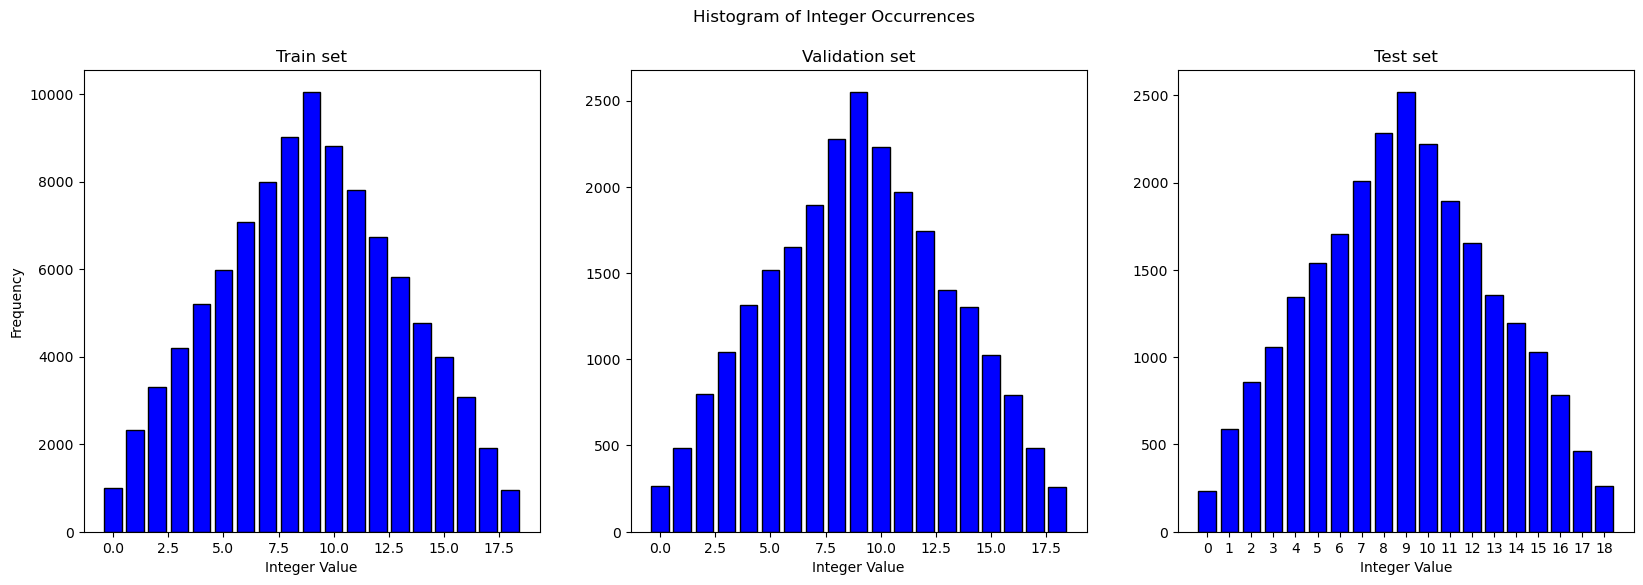

In [5]:
num_classes = 19

new_x_train, new_y_train = gen_dataset(x_train, y_train, 100000)
new_x_val, new_y_val = gen_dataset(x_val, y_val, 25000)
new_x_test, new_y_test = gen_dataset(x_test, y_test, 25000)

print('new_x_train shape:', new_x_train.shape)
print(new_x_train.shape[0], 'train samples')
print(new_x_val.shape[0], 'validation samples')
print(new_x_test.shape[0], 'test samples')

plot_data_hist(new_y_train, new_y_val, new_y_test)

In [6]:
new_y_train = to_categorical(new_y_train, num_classes)
new_y_val = to_categorical(new_y_val, num_classes)
new_y_test = to_categorical(new_y_test, num_classes)

## Q2

In [7]:
# Optuna objective function
def objective(trial):
    """
    Objective function for optimising the hyperparameters of the neural network
    """
    # Suggest hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh']) 
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    units = trial.suggest_int('units', 32, 512) 
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Build the model
    model = Sequential()
    model.add(Flatten(input_shape=(56, 28))) # Input layer
    
    for _ in range(num_layers): # Hidden layers

        model.add(Dense(units=units, activation=activation))
        model.add(BatchNormalization())                      
        model.add(Dropout(rate=dropout_rate))   
    
    model.add(Dense(num_classes, activation='softmax')) # Output layer
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(new_x_train, new_y_train, 
                        epochs=20, 
                        batch_size=128,
                        verbose=0)
    
    # Evaluate the model
    score = model.evaluate(new_x_val, new_y_val, verbose=0)
    accuracy = score[1]

    trial.set_user_attr("validation_accuracy", accuracy) # Store accuracies for plotting to see how the hyperparameter tuning evolves

    return accuracy

# Create an Optuna study and optimize the objective function
sampler = optuna.samplers.TPESampler(seed=10)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)  # Set the number of trials

validation_accuracies_nn = [trial.user_attrs["validation_accuracy"] for trial in study.trials] # Retreive accuracies for all the trials in the study

# Print the best trial
print('Best trial:')
print(f' Value: {study.best_trial.value}')
print(' Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-12-17 08:55:15,500] A new study created in memory with name: no-name-81b12059-bc9a-4938-a506-f82303cc57e9
/Users/panosantonopoulos/anaconda3/envs/M1_coursework_conda_environment/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-12-17 08:55:15.514665: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-17 08:55:15.514700: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-17 08:55:15.514707: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-17 08:55:15.514727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA suppo

Best trial:
 Value: 0.9461600184440613
 Params: 
    num_layers: 5
    activation: sigmoid
    dropout_rate: 0.2984215744011278
    units: 418
    learning_rate: 0.0007565995480433036


#### Save all the validation accuracies to file

In [8]:
df_nn = pd.DataFrame(validation_accuracies_nn, columns=["val_acc"])
df_nn.to_csv("../data/nn_validation_accuracies.csv", index=False)

#### Access the optimal hyperparameters and then save to file

In [9]:
optimum_hyperparams = []

for key, value in study.best_trial.params.items():
    optimum_hyperparams.append(value)

In [10]:
df_opt = pd.DataFrame({
    'hyperparams': optimum_hyperparams,
    'type': [type(item).__name__ for item in optimum_hyperparams]
})

# Save to CSV
df_opt.to_csv('../data/nn_opt_hyperparams.csv', index=False)

## Q3

#### Re-format the data to work with sklearn implementation of random forest and svm

In [11]:
# Flatten each image
flat_x_train = new_x_train.reshape(new_x_train.shape[0], -1)  
flat_x_val = new_x_val.reshape(new_x_val.shape[0], -1)  
flat_x_test = new_x_test.reshape(new_x_test.shape[0], -1)  

# Convert one-hot encoding back to integer labels
int_y_train = np.argmax(new_y_train, axis=1) 
int_y_val = np.argmax(new_y_val, axis=1)  
int_y_test = np.argmax(new_y_test, axis=1)  

### Random forest

In [12]:
# Optuna objective function
def rf_objective(trial):
    """
    Objective function for optimising the hyperparameters of the random forest
    """
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 2, 200)
    
    
    # Build the model
    RndFrstClass = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
    RndFrstClass.fit(flat_x_train, int_y_train) 

    accuracy = RndFrstClass.score(flat_x_val, int_y_val)   
    trial.set_user_attr("validation_accuracy", accuracy) # Store accuracies for plotting to see how the hyperparameter tuning evolves
    
    return accuracy

# Create an Optuna study and optimize the objective function
sampler = optuna.samplers.TPESampler(seed=10)
studyrf = optuna.create_study(direction='maximize', sampler=sampler)
studyrf.optimize(rf_objective, n_trials=50)  # Set the number of trials

validation_accuracies_rf = [trial.user_attrs["validation_accuracy"] for trial in studyrf.trials] # Retreive accuracies for all the trials in the study

# Print the best trial
print('Best trial:')
print(f' Value: {studyrf.best_trial.value}')
print(' Params: ')
for key, value in studyrf.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-12-17 14:49:13,478] A new study created in memory with name: no-name-050886d1-43b7-40a2-902e-3de91b491e47
[I 2024-12-17 14:50:00,775] Trial 0 finished with value: 0.4172 and parameters: {'n_estimators': 234, 'max_depth': 6}. Best is trial 0 with value: 0.4172.
[I 2024-12-17 14:52:04,219] Trial 1 finished with value: 0.8076 and parameters: {'n_estimators': 194, 'max_depth': 151}. Best is trial 1 with value: 0.8076.
[I 2024-12-17 14:53:40,116] Trial 2 finished with value: 0.8012 and parameters: {'n_estimators': 155, 'max_depth': 46}. Best is trial 1 with value: 0.8076.
[I 2024-12-17 14:54:21,757] Trial 3 finished with value: 0.77616 and parameters: {'n_estimators': 67, 'max_depth': 153}. Best is trial 1 with value: 0.8076.
[I 2024-12-17 14:54:56,531] Trial 4 finished with value: 0.76668 and parameters: {'n_estimators': 59, 'max_depth': 19}. Best is trial 1 with value: 0.8076.
[I 2024-12-17 14:57:06,511] Trial 5 finished with value: 0.81132 and parameters: {'n_estimators': 209, 'm

Best trial:
 Value: 0.81644
 Params: 
    n_estimators: 285
    max_depth: 196


#### Save the validation accuracies to file

In [13]:
df_rf = pd.DataFrame(validation_accuracies_rf, columns=["val_acc"])
df_rf.to_csv("../data/rf_validation_accuracies.csv", index=False)

#### Access the optimal hyperparameters and then save to file

In [14]:
optimum_hyperparams_rf = []

for key, value in studyrf.best_trial.params.items():
    optimum_hyperparams_rf.append(value)

In [15]:
df_opt_rf = pd.DataFrame({
    'hyperparams': optimum_hyperparams_rf,
    'type': [type(item).__name__ for item in optimum_hyperparams_rf]
})

# Save to CSV
df_opt_rf.to_csv('../data/opt_hyperparams_rf.csv', index=False)

### SVM

In [16]:
# Optuna objective function
def svm_objective(trial):
    """
    Objective function for optimising the hyperparameters of the SVM
    """
    # Suggest hyperparameters
    C = trial.suggest_float('C', 0.1, 100)
    gamma = trial.suggest_float('gamma', 1e-3, 1, log=True)
    
    # Build the model
    svcClass = SVC(C=C, gamma=gamma)
    svcClass.fit(flat_x_train[:5000], int_y_train[:5000])

    accuracy =  svcClass.score(flat_x_val[:5000], int_y_val[:5000])
    trial.set_user_attr("validation_accuracy", accuracy) # Store accuracies for plotting to see how the hyperparameter tuning evolves

    return accuracy

# Create an Optuna study and optimize the objective function
sampler = optuna.samplers.TPESampler(seed=10)
studysvm = optuna.create_study(direction='maximize', sampler=sampler)
studysvm.optimize(svm_objective, n_trials=50)  # Set the number of trials

validation_accuracies_svm = [trial.user_attrs["validation_accuracy"] for trial in studysvm.trials] # Retreive accuracies for all the trials in the study

# Print the best trial
print('Best trial:')
print(f' Value: {studysvm.best_trial.value}')
print(' Params: ')
for key, value in studysvm.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-12-17 16:56:41,532] A new study created in memory with name: no-name-1111ed6a-a64d-488c-81ed-c3c8a67d6464
[I 2024-12-17 16:57:05,823] Trial 0 finished with value: 0.4186 and parameters: {'C': 77.15493226234793, 'gamma': 0.001154132971137168}. Best is trial 0 with value: 0.4186.
[I 2024-12-17 16:57:33,741] Trial 1 finished with value: 0.0972 and parameters: {'C': 63.40145866913492, 'gamma': 0.17636469336159116}. Best is trial 0 with value: 0.4186.
[I 2024-12-17 16:57:58,574] Trial 2 finished with value: 0.5372 and parameters: {'C': 49.90085052902879, 'gamma': 0.00472487079152679}. Best is trial 2 with value: 0.5372.
[I 2024-12-17 16:58:26,152] Trial 3 finished with value: 0.0972 and parameters: {'C': 19.886480189486438, 'gamma': 0.1912459014251737}. Best is trial 2 with value: 0.5372.
[I 2024-12-17 16:58:49,135] Trial 4 finished with value: 0.4556 and parameters: {'C': 16.994172572597293, 'gamma': 0.0018408544111075849}. Best is trial 2 with value: 0.5372.
[I 2024-12-17 16:59:16

Best trial:
 Value: 0.5796
 Params: 
    C: 27.572037319938246
    gamma: 0.01305628749775024


#### Save the validation accuracies to file

In [17]:
df_svm = pd.DataFrame(validation_accuracies_svm, columns=["val_acc"])
df_svm.to_csv("../data/svm_validation_accuracies.csv", index=False)

#### Access the optimal hyperparameters and then save to file

In [18]:
optimum_hyperparams_svm = []

for key, value in studysvm.best_trial.params.items():
    optimum_hyperparams_svm.append(value)

In [ ]:
df_opt_svm = pd.DataFrame({
    'hyperparams': optimum_hyperparams_svm,
    'type': [type(item).__name__ for item in optimum_hyperparams_svm]
})

# Save to CSV
df_opt_svm.to_csv('../data/opt_hyperparams_svm.csv', index=False)